### 국가별 사용하는 알파벳 개수 학습을 통한 국가 분류 <hr>

In [2]:
# 모듈로딩
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn           
import torch.nn.functional as F 
import torch.optim as optim
import torchmetrics.functional as metrics
import torchmetrics.functional.classification as metrics
import sklearn.metrics as skm

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

from glob import glob
from natsort import natsorted

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES = 4

In [4]:
train_file = '../DATA/lang_data/train/'
test_file = '../DATA/lang_data/test/' 

In [5]:
file_list = glob(train_file + '*.txt')
file_list = natsorted(file_list)
file_list

['../DATA/lang_data/train\\en-1.txt',
 '../DATA/lang_data/train\\en-2.txt',
 '../DATA/lang_data/train\\en-3.txt',
 '../DATA/lang_data/train\\en-4.txt',
 '../DATA/lang_data/train\\en-5.txt',
 '../DATA/lang_data/train\\en-6.txt',
 '../DATA/lang_data/train\\en-7.txt',
 '../DATA/lang_data/train\\en-8.txt',
 '../DATA/lang_data/train\\en-9.txt',
 '../DATA/lang_data/train\\en-10.txt',
 '../DATA/lang_data/train\\fr-1.txt',
 '../DATA/lang_data/train\\fr-2.txt',
 '../DATA/lang_data/train\\fr-3.txt',
 '../DATA/lang_data/train\\fr-4.txt',
 '../DATA/lang_data/train\\fr-5.txt',
 '../DATA/lang_data/train\\fr-6.txt',
 '../DATA/lang_data/train\\fr-7.txt',
 '../DATA/lang_data/train\\fr-8.txt',
 '../DATA/lang_data/train\\fr-9.txt',
 '../DATA/lang_data/train\\fr-10.txt',
 '../DATA/lang_data/train\\id-11.txt',
 '../DATA/lang_data/train\\id-12.txt',
 '../DATA/lang_data/train\\id-13.txt',
 '../DATA/lang_data/train\\id-14.txt',
 '../DATA/lang_data/train\\id-15.txt',
 '../DATA/lang_data/train\\id-16.txt',
 '..

In [7]:
f = open(file_list[0], 'r')
lines = f.readlines()
f.close()
lines

['\n',
 '\n',
 '\n',
 '\n',
 'The main Henry Ford Museum building houses some of the classrooms for the Henry Ford Academy\n',
 '\n',
 '\n',
 'Henry Ford Academy is the first charter school in the United States to be developed jointly by a global corporation, public education, and a major nonprofit cultural institution. The school is sponsored by the Ford Motor Company, Wayne County Regional Educational Service Agency and The Henry Ford Museum and admits high school students. It is located in Dearborn, Michigan on the campus of the Henry Ford museum. Enrollment is taken from a lottery in the area and totaled 467 in 2010.[1]\n',
 'Freshman meet inside the main museum building in glass walled classrooms, while older students use a converted carousel building and Pullman cars on a siding of the Greenfield Village railroad. Classes are expected to include use of the museum artifacts, a tradition of the original Village Schools. When the Museum was established in 1929, it included a school 

In [8]:
lines = list(set(lines))

In [9]:
lines.remove('\n')

In [10]:
lines

['Livingston\n',
 'Skyscrapers\n',
 'Port Huron\n',
 'Closed\n',
 'Renaissance\n',
 'Benjamin Franklin (Livonia)\n',
 'Plymouth-Canton Educational Park (Canton)\n',
 'Ford\n',
 'Winston Churchill (Livonia)\n',
 'Trenton\n',
 'Public high schools\n',
 'Catherine Ferguson Academy (alternative)\n',
 'Lake St. Clair\n',
 'University Liggett School\n',
 'Barsamian Preparatory Center\n',
 'Harry S. Truman (Taylor)\n',
 'Woodhaven (Brownstown Township)\n',
 'Clinton Township\n',
 'Monroe\n',
 'Troy\n',
 'Edsel Ford (Dearborn)\n',
 'Other public schools\n',
 'Dearborn\n',
 'Independent\n',
 'Romulus\n',
 'Davis Aerospace\n',
 'Religious\n',
 'Brighton\n',
 'Auburn Hills\n',
 'Clara B. Ford Academy (Dearborn Heights)\n',
 'Inter-City Baptist School\n',
 'Genesee\n',
 'Moved\n',
 '40,000 to 80,000\n',
 'Culture\n',
 'Redford Township\n',
 'John F. Kennedy (Taylor)\n',
 'Cornerstone Schools High School (Detroit)\n',
 'Warren\n',
 'Flat Rock\n',
 'River Rouge\n',
 '^ Technology Plan, Henry Ford Ac

In [11]:
len(lines)

222

In [12]:
lines[0].rstrip('\n')

'Livingston'

In [13]:
lines = [lines[i].rstrip('\n') for i in range(len(lines))]

In [14]:
lines

['Livingston',
 'Skyscrapers',
 'Port Huron',
 'Closed',
 'Renaissance',
 'Benjamin Franklin (Livonia)',
 'Plymouth-Canton Educational Park (Canton)',
 'Ford',
 'Winston Churchill (Livonia)',
 'Trenton',
 'Public high schools',
 'Catherine Ferguson Academy (alternative)',
 'Lake St. Clair',
 'University Liggett School',
 'Barsamian Preparatory Center',
 'Harry S. Truman (Taylor)',
 'Woodhaven (Brownstown Township)',
 'Clinton Township',
 'Monroe',
 'Troy',
 'Edsel Ford (Dearborn)',
 'Other public schools',
 'Dearborn',
 'Independent',
 'Romulus',
 'Davis Aerospace',
 'Religious',
 'Brighton',
 'Auburn Hills',
 'Clara B. Ford Academy (Dearborn Heights)',
 'Inter-City Baptist School',
 'Genesee',
 'Moved',
 '40,000 to 80,000',
 'Culture',
 'Redford Township',
 'John F. Kennedy (Taylor)',
 'Cornerstone Schools High School (Detroit)',
 'Warren',
 'Flat Rock',
 'River Rouge',
 '^ Technology Plan, Henry Ford Academy, 2010]',
 'Detroit International Academy for Young Women',
 'Economy',
 'Aca

In [15]:
Alphabet = 'abcdefghijklmnopqrstuvwxyz'
def count_alphabets(string):
    # 대문자를 소문자로 변환
    string = string.lower()
    # print(string)

    # 각 알파벳의 개수가 들어갈 0으로 구성된 리스트를 만든다.
    alphabet_freq = [0] * 26

    for ch in string:
        if ch in Alphabet:
            idx = Alphabet.find(ch)
            alphabet_freq[idx] += 1
    
    return alphabet_freq

### 라인당 알파벳 개수 고려하지 않고 데이터 정제 <hr>

- 훈련 데이터 준비

In [16]:
file_list1 = glob(train_file + '*.txt')
file_list1 = natsorted(file_list1)

data1 = []
file_num1 = len(file_list1)

for index in range(file_num1):
    f = open(file_list[index], 'r')
    lines = f.readlines()
    lines = list(set(lines))
    lines.remove('\n')
    lines = [lines[i].rstrip('\n') for i in range(len(lines))]
    words = []
    for line in lines:
        words += line.split()
        
    for word in words:
        alphabet_freq = count_alphabets(word)
        sample = alphabet_freq + [index // 10]  # 0 : en, 1 : fr, 2 : id, 3 : tl 
        data1.append(sample) 
    f.close()

In [17]:
len(file_list1)

40

In [18]:
# 공백을 기준으로 분리된 단어의 알파벳 빈도수로 구성된 훈련 데이터를 데이터프레임으로 준비
columns = list(Alphabet) + ['nation']
trainDF = pd.DataFrame(data1, columns = columns)
trainDF.head()

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,nation
0,0,0,0,0,0,0,1,0,2,0,...,0,1,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,...,2,3,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0,1,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [19]:
trainDF.tail()

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,nation
116195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
116196,3,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,3
116197,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
116198,3,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,3
116199,3,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,3


In [20]:
trainDF.shape

(116200, 27)

- 테스트 세트 준비

In [21]:
file_list2 = glob(test_file + '*.txt')
file_list2 = natsorted(file_list2)

data2 = []
file_num2 = len(file_list2)

for index in range(file_num2):
    f = open(file_list[index], 'r')
    lines = f.readlines()
    lines = list(set(lines))
    lines.remove('\n')
    lines = [lines[i].rstrip('\n') for i in range(len(lines))]
    words = []
    for line in lines:
        words += line.split()
        
    for word in words:
        alphabet_freq = count_alphabets(word)
        sample = alphabet_freq + [index // 4]  # 0 : en, 1 : fr, 2 : id, 3 : tl 
        data2.append(sample) 
    f.close()

In [22]:
# 공백을 기준으로 분리된 단어의 알파벳 빈도수로 구성된 테스트 데이터를 데이터프레임으로 준비
columns = list(Alphabet) + ['nation']
testDF = pd.DataFrame(data2, columns = columns)
testDF.head()

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,nation
0,0,0,0,0,0,0,1,0,2,0,...,0,1,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,...,2,3,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0,1,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [23]:
testDF.tail()

,a,b,c,d,e,f,g,h,i,j,...,r,s,t,u,v,w,x,y,z,nation
54655,1,0,0,0,2,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,3
54656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
54657,2,0,2,0,0,1,0,0,3,0,...,0,2,1,0,0,0,0,0,0,3
54658,1,0,0,0,1,0,2,1,1,0,...,1,0,0,1,0,0,0,0,0,3
54659,0,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,3


In [24]:
testDF.shape

(54660, 27)

#### 학습을 위한 데이터 준비 <hr>

In [25]:
# 피처, 타겟 데이터 분리
featureDF = trainDF[trainDF.columns[:-1]]
targetDF = trainDF.nation.to_frame()

In [26]:
# shape 확인
print(f'featureDF => {featureDF.shape}, targetSR => {targetDF.shape}')

featureDF => (116200, 26), targetSR => (116200, 1)


In [27]:
targetDF.values.shape

(116200, 1)

In [28]:
target = torch.tensor(targetDF.values)
target

tensor([[0],
        [0],
        [0],
        ...,
        [3],
        [3],
        [3]])

In [29]:
F.one_hot(target, num_classes = 4).squeeze(1)

tensor([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1]])

In [30]:
# 타겟을 원핫으로 변환
target = torch.tensor(targetDF.values)
target = F.one_hot(target, num_classes = 4).squeeze(1)

In [31]:
targetNP = np.array(target)
targetNP

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=int64)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(featureDF, targetNP, test_size = 0.1, random_state = 42, stratify = targetNP)

In [33]:
X_test = testDF[testDF.columns[:-1]]
y_test = np.array(F.one_hot(torch.tensor(testDF.nation.values), num_classes = 4))

In [34]:
# 데이터의 Tensor 변환
class DLDataset(Dataset):

    # 초기화 콜백 함수(callback function)
    def __init__(self, x_data, y_data):
        super().__init__()
        # x, y 데이터 => ndarray
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data
        y_data = y_data.values if isinstance(y_data, pd.Series) else y_data

        # ndarray => tensor
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.FloatTensor(y_data)  # 타겟을 원핫인코딩하면 FloatTensor 사용
        print('[target & target shape]', self.target.shape, self.target.ndim)
    
    # 데이터셋의 개수 체크 콜백 함수(callback function)
    def __len__(self):
        return self.target.shape[0]
    
    # 특정 인덱스 데이터 + 라벨 반환 콜백 함수(callback function)
    def __getitem__(self, index):
        return self.feature[index], self.target[index]

In [35]:
trainDS = DLDataset(X_train, y_train)
validDS = DLDataset(X_val, y_val)
testDS = DLDataset(X_test, y_test)

[target & target shape] torch.Size([104580, 4]) 2
[target & target shape] torch.Size([11620, 4]) 2
[target & target shape] torch.Size([54660, 4]) 2


In [36]:
batch_size = 128
trainDL = DataLoader(trainDS, batch_size = batch_size, shuffle = True, drop_last = True)
validDL = DataLoader(validDS, batch_size = batch_size, shuffle = True, drop_last = True)
testDL = DataLoader(testDS, batch_size = batch_size, shuffle = True, drop_last = True)

In [37]:
# Epoch당 반복 단위
print(f'batch_size = {batch_size}')
print(f'trainDL => {len(trainDL)}개, validDL => {len(validDL)}개, testDL => {len(testDL)}개')

batch_size = 128
trainDL => 817개, validDL => 90개, testDL => 427개


In [38]:
class NationModel(nn.Module):
    
    # 모델 구성 요소 초기화 
    def __init__(self, in_dim, out_dim, nodes_list = []):
        super().__init__()
        nodes_list.insert(0, in_dim)
        nodes_list.append(out_dim)
        layer_num = len(nodes_list) - 1
        layers = []
        for i in range(layer_num):
            if i <= layer_num - 2:
                layers.append(nn.Linear(nodes_list[i], nodes_list[i + 1]))
                layers.append(nn.BatchNorm1d(num_features = nodes_list[i+1]))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout())    
            else:
                layers.append(nn.Linear(nodes_list[i], nodes_list[i + 1]))
        
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [39]:
# model = NationModel(26, 4, [16, 8 ,4])
# LOSS_FN = LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)
# OPTIMIZER = optim.Adam(model.parameters())
# SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 3)

In [44]:
### ===> 학습 진행함수 
def training(epoch):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    model.train()
    
    # 배치크기 만큼 학습 진행 및 저장
    train_report=[[], [], []]
    for idx, (feature, target)  in enumerate(trainDL):
        # 배치크기만큼의 학습 데이터 준비
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        
        # 학습
        pre_target = model(feature)

        # 손실계산
        loss = LOSS_FN(pre_target, target)
        train_report[0].append(loss)
        
        # 성능 평가
        acc = metrics.accuracy(pre_target.argmax(dim = 1), target.argmax(dim = 1), task='multiclass', num_classes = CLASSES)
        train_report[1].append(acc)

        f1 = metrics.f1_score(pre_target.argmax(dim = 1), target.argmax(dim = 1), task='multiclass', num_classes = CLASSES)
        train_report[2].append(f1)
     
        # W,b업데이트
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
        
        if not idx%50: print('.', end='')
    
    # 에포크 단위로 학습 모델 저장
    # torch.save(model, './model/my_model.pt')
    
    # 에포크 단위 학습 진행 메시지 출력
    loss_score = (sum(train_report[0])/len(trainDL)).item()
    acc_score = (sum(train_report[1])/len(trainDL)).item()
    f1_score = (sum(train_report[2])/len(trainDL)).item() 
    print(f'\n[{epoch+1} Train ] Loss ==> {loss_score:.3f} Acc ==> {acc_score:.3f} F1 ==> {f1_score:.3f}')
    
    return loss_score, acc_score, f1_score

In [45]:
### ===> 검증 및 테스트 진행함수 
def testing(epoch, kind='valid'):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    model.eval()
        
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장
        test_report=[[], [], []]
        for idx, (feature, target) in enumerate(validDL):
            # 배치크기만큼의 학습 데이터 준비
            feature, target = feature.to(DEVICE), target.to(DEVICE)

            # 학습
            pre_traget = model(feature)

            # 손실계산
            loss = LOSS_FN(pre_traget, target)
            test_report[0].append(loss)
            
            # 성능 평가 
            acc = metrics.accuracy(pre_traget.argmax(dim = 1), target.argmax(dim = 1), task='multiclass', num_classes = CLASSES)
            test_report[1].append(acc)
            
            f1 = metrics.f1_score(pre_traget.argmax(dim = 1), target.argmax(dim = 1), task='multiclass', num_classes = CLASSES)
            test_report[2].append(f1)
            
            #if not idx%50: print('.', end='')

    testing_type = 'Valid' if kind == 'valid' else 'Test'
        
    # 에포크 단위 학습 진행 메시지 출력
    loss_score = (sum(test_report[0])/len(validDL)).item()
    acc_score = (sum(test_report[1])/len(validDL)).item()
    f1_score = (sum(test_report[2])/len(validDL)).item() 
    print(f'[{epoch+1} {testing_type} ] Loss ==> {loss_score:.3f} Acc ==> {acc_score:.3f} F1 ==> {f1_score:.3f}\n')
    
    return loss_score, acc_score, f1_score

In [46]:
len(np.unique(y_train, axis = 0))

4

In [47]:
layer = [16, 8, 4]

loss_list1 = [[], []]
acc_list1 = [[], []]
f1_score_list1 = [[], []]

EPOCHS = 100

IN_DIM, OUT_DIM = X_train.shape[1], len(np.unique(y_train, axis = 0))
model = NationModel(IN_DIM, OUT_DIM, layer)
for _, modelList in model.named_children():
    for child in modelList:
        if isinstance(child, nn.Linear):
            nn.init.kaiming_normal_(child.weight)
OPTIMIZER = optim.Adam(model.parameters())
LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)

print(f'IN : {IN_DIM}, OUT : {OUT_DIM}')

train_ = {'loss':[], 'acc':[], 'f1':[]}
val_ = {'loss':[], 'acc':[], 'f1':[]}

pre_va_score = 100

for epo in range(EPOCHS):
    print(f"[Epoch {epo+1}/{EPOCHS}] ", end='')

    tr_score=training(epo)
    va_score=testing(epo)

    if pre_va_score > va_score[0]:
        torch.save(model, '../model/my_model1.pt')
        pre_va_score = va_score[0]

    for idx, key in enumerate(train_):
        train_[key].append(tr_score[idx])
        val_[key].append(va_score[idx])
    
    SCHEDULER.step(va_score[0])
    # 조기종료 기능 => 조건 : val_loss가 지정된 횟수이상 개선이 안되면 학습 종료
    if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
        print(f'Early stopping at epoch {epo}')
        break
    
    loss_list1[0].append(tr_score[0])
    loss_list1[1].append(va_score[0])
    acc_list1[0].append(tr_score[1])
    acc_list1[1].append(va_score[1])
    f1_score_list1[0].append(tr_score[2])
    f1_score_list1[1].append(va_score[2])

print("Done!")

IN : 26, OUT : 4
[Epoch 1/100] .................
[1 Train ] Loss ==> 1.432 Acc ==> 0.313 F1 ==> 0.313
[1 Valid ] Loss ==> 1.353 Acc ==> 0.341 F1 ==> 0.341

[Epoch 2/100] .................
[2 Train ] Loss ==> 1.352 Acc ==> 0.341 F1 ==> 0.341
[2 Valid ] Loss ==> 1.314 Acc ==> 0.341 F1 ==> 0.341

[Epoch 3/100] .................
[3 Train ] Loss ==> 1.321 Acc ==> 0.351 F1 ==> 0.351
[3 Valid ] Loss ==> 1.257 Acc ==> 0.457 F1 ==> 0.457

[Epoch 4/100] .................
[4 Train ] Loss ==> 1.283 Acc ==> 0.382 F1 ==> 0.382
[4 Valid ] Loss ==> 1.195 Acc ==> 0.480 F1 ==> 0.480

[Epoch 5/100] .................
[5 Train ] Loss ==> 1.262 Acc ==> 0.399 F1 ==> 0.399
[5 Valid ] Loss ==> 1.182 Acc ==> 0.471 F1 ==> 0.471

[Epoch 6/100] .................
[6 Train ] Loss ==> 1.246 Acc ==> 0.413 F1 ==> 0.413
[6 Valid ] Loss ==> 1.157 Acc ==> 0.484 F1 ==> 0.484

[Epoch 7/100] .................
[7 Train ] Loss ==> 1.234 Acc ==> 0.426 F1 ==> 0.426
[7 Valid ] Loss ==> 1.146 Acc ==> 0.486 F1 ==> 0.486

[Epoch 8/1

In [48]:
epo

28

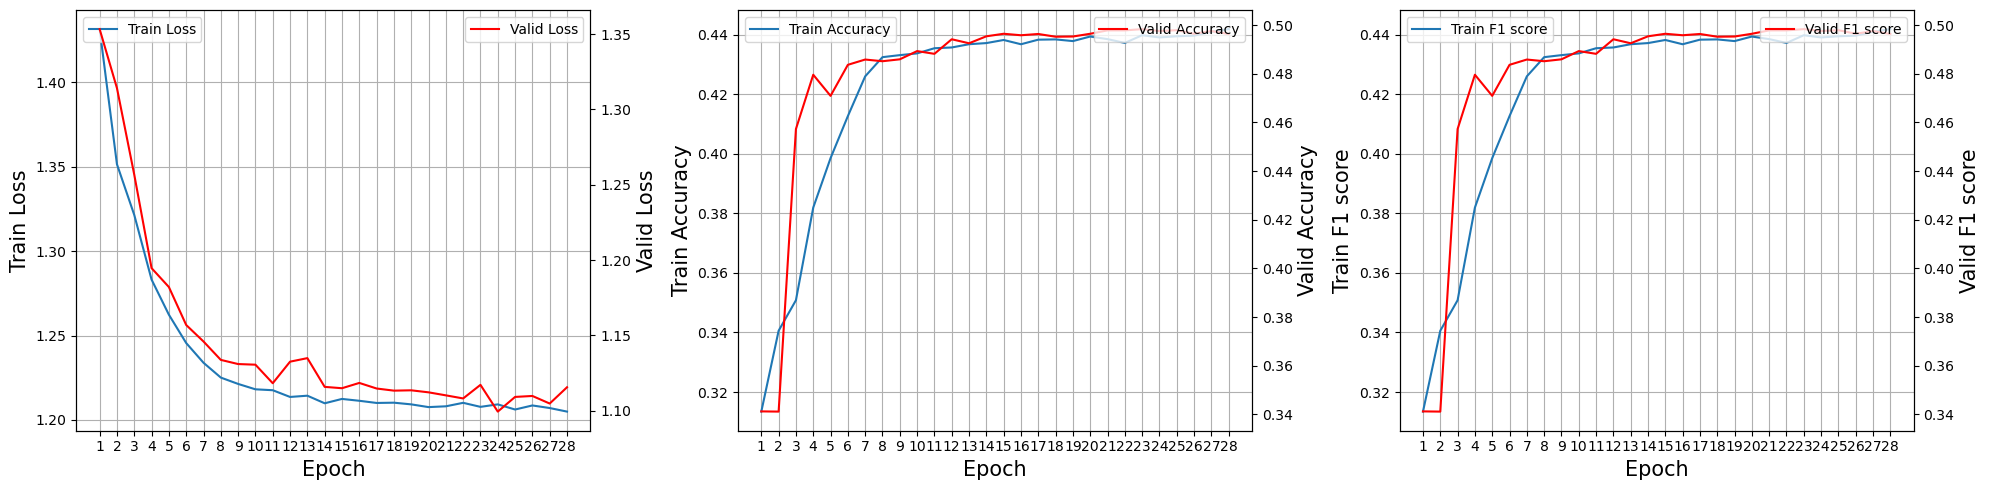

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(loss_list1[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Epoch", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(epo))
axes[0].set_xticklabels(np.arange(1, 1+epo))
#axes[0].tick_params(axis = 'x', rotation = 30)

axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list1[1], label = "Valid Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Loss", size = 15)

axes[1].plot(acc_list1[0], label = "Train Accuracy")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Epoch", size = 15)
axes[1].set_ylabel("Train Accuracy", size = 15)
axes[1].set_xticks(np.arange(epo))
axes[1].set_xticklabels(np.arange(1, 1+epo))
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(acc_list1[1], label = "Valid Accuracy", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Accuracy", size = 15)

axes[2].plot(f1_score_list1[0], label = "Train F1 score")
axes[2].legend(loc="upper left")
axes[2].set_xlabel("Epoch", size = 15)
axes[2].set_ylabel("Train F1 score", size = 15)
axes[2].set_xticks(np.arange(epo))
axes[2].set_xticklabels(np.arange(1, 1+epo))

axes[2].grid()
axes2 = axes[2].twinx()
axes2.plot(f1_score_list1[1], label = "Valid F1 score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid F1 score", size = 15)
plt.tight_layout()
plt.show()

In [50]:
# 저장된 모델 불러오기
mymodel = torch.load('../model/my_model1.pt')
mymodel

NationModel(
  (layers): ModuleList(
    (0): Linear(in_features=26, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=8, out_features=4, bias=True)
    (9): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=4, out_features=4, bias=True)
  )
)

In [51]:
# 예측 함수
def predict(dataSet):
    
    mymodel.eval()
    
    with torch.no_grad():
        input = dataSet.feature
        output = mymodel(input)
        pre_target = output.argmax(dim = 1)

    return pre_target

In [56]:
predict(testDS)

tensor([0, 0, 0,  ..., 0, 0, 0])

In [53]:
len(testDS)

54660

In [54]:
metrics.accuracy(predict(testDS), testDS.target.argmax(dim = 1), task = 'multiclass', num_classes = 4).item()

0.08214416354894638

In [55]:
metrics.f1_score(predict(testDS), testDS.target.argmax(dim = 1), task = 'multiclass', num_classes = 4).item()

0.08214416354894638

### 라인당 알파벳 개수 고려하여 데이터 정제 <hr>